In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)
df = pd.read_csv("Phishing_Legitimate_full.csv")  # Adjust path as needed
print(df.shape)
print("Dataset shape:", df.shape)
print(df.head())

(10000, 50)
Dataset shape: (10000, 50)
   id  NumDots  SubdomainLevel  PathLevel  UrlLength  NumDash  \
0   1        3               1          5         72        0   
1   2        3               1          3        144        0   
2   3        3               1          2         58        0   
3   4        3               1          6         79        1   
4   5        3               0          4         46        0   

   NumDashInHostname  AtSymbol  TildeSymbol  NumUnderscore  ...  \
0                  0         0            0              0  ...   
1                  0         0            0              2  ...   
2                  0         0            0              0  ...   
3                  0         0            0              0  ...   
4                  0         0            0              0  ...   

   IframeOrFrame  MissingTitle  ImagesOnlyInForm  SubdomainLevelRT  \
0              0             0                 1                 1   
1              0           

In [3]:
# Target label: CLASS_LABEL (1 = phishing, 0 = legitimate)
y = df["CLASS_LABEL"].values
X = df.drop(columns=["id", "CLASS_LABEL"], errors="ignore").values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
for epoch in range(20):
    optimizer.zero_grad()
    out = model(X_train_t)
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()
print("Model trained.")

Model trained.


In [8]:
def eval_accuracy(model, X, y):
    with torch.no_grad():
        preds = torch.argmax(model(X), dim=1)
    return (preds == y).float().mean().item()

acc_clean = eval_accuracy(model, X_test_t, y_test_t)
print(f"Baseline test accuracy: {acc_clean:.4f}")

Baseline test accuracy: 0.8565


In [9]:
# ==========================================
# FGSM and PGD Attacks
# ==========================================
def fgsm_attack(model, X, y, epsilon):
    X_adv = X.clone().detach().requires_grad_(True)
    outputs = model(X_adv)
    loss = criterion(outputs, y)
    loss.backward()
    X_adv = X_adv + epsilon * X_adv.grad.sign()
    return torch.clamp(X_adv, -3, 3)

def pgd_attack(model, X, y, epsilon, alpha=0.01, steps=10):
    X_adv = X.clone().detach()
    for _ in range(steps):
        X_adv.requires_grad_(True)
        outputs = model(X_adv)
        loss = criterion(outputs, y)
        loss.backward()
        with torch.no_grad():
            X_adv = X_adv + alpha * X_adv.grad.sign()
            perturbation = torch.clamp(X_adv - X, min=-epsilon, max=epsilon)
            X_adv = torch.clamp(X + perturbation, -3, 3)
    return X_adv.detach()

In [10]:
# ==========================================
# Evaluate Robustness Curve + RI
# ==========================================
epsilons = np.linspace(0, 0.3, 10)
acc_fgsm, acc_pgd = [], []

for eps in epsilons:
    X_fgsm = fgsm_attack(model, X_test_t, y_test_t, eps)
    X_pgd = pgd_attack(model, X_test_t, y_test_t, eps)
    acc_fgsm.append(eval_accuracy(model, X_fgsm, y_test_t))
    acc_pgd.append(eval_accuracy(model, X_pgd, y_test_t))
    print(f"ε={eps:.3f} → FGSM={acc_fgsm[-1]:.3f}, PGD={acc_pgd[-1]:.3f}")

ε=0.000 → FGSM=0.864, PGD=0.864
ε=0.033 → FGSM=0.817, PGD=0.817
ε=0.067 → FGSM=0.761, PGD=0.757
ε=0.100 → FGSM=0.702, PGD=0.695
ε=0.133 → FGSM=0.640, PGD=0.695
ε=0.167 → FGSM=0.572, PGD=0.695
ε=0.200 → FGSM=0.516, PGD=0.695
ε=0.233 → FGSM=0.465, PGD=0.695
ε=0.267 → FGSM=0.408, PGD=0.695
ε=0.300 → FGSM=0.357, PGD=0.695


In [11]:
# Compute Robustness Index (area under accuracy curve)
RI_fgsm = np.trapz(acc_fgsm, epsilons) / (epsilons[-1] - epsilons[0])
RI_pgd = np.trapz(acc_pgd, epsilons) / (epsilons[-1] - epsilons[0])
print(f"Robustness Index (FGSM) = {RI_fgsm:.3f}")
print(f"Robustness Index (PGD)  = {RI_pgd:.3f}")

Robustness Index (FGSM) = 0.610
Robustness Index (PGD)  = 0.725


/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/3211529494.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_fgsm = np.trapz(acc_fgsm, epsilons) / (epsilons[-1] - epsilons[0])
/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/3211529494.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_pgd = np.trapz(acc_pgd, epsilons) / (epsilons[-1] - epsilons[0])


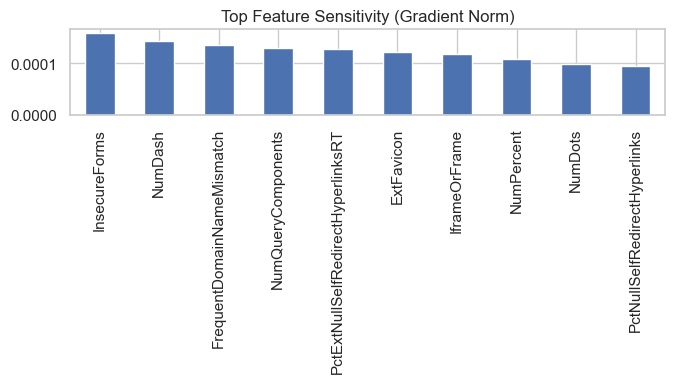

In [13]:
# ==========================================
# Feature Gradient Sensitivity
# ==========================================
X_sample = X_test_t[:256].clone().detach().requires_grad_(True)
out = model(X_sample)
loss = criterion(out, y_test_t[:256])
loss.backward()
sensitivity = X_sample.grad.abs().mean(dim=0).cpu().numpy()

cols = df.drop(columns=["id", "CLASS_LABEL"], errors="ignore").columns
sens_series = pd.Series(sensitivity, index=cols).sort_values(ascending=False)

top_k = sens_series.head(10)
top_k.plot(kind="bar")
plt.title("Top Feature Sensitivity (Gradient Norm)")
plt.tight_layout()
plt.savefig("feature_sensitivity.png", dpi=300)
plt.show()

/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


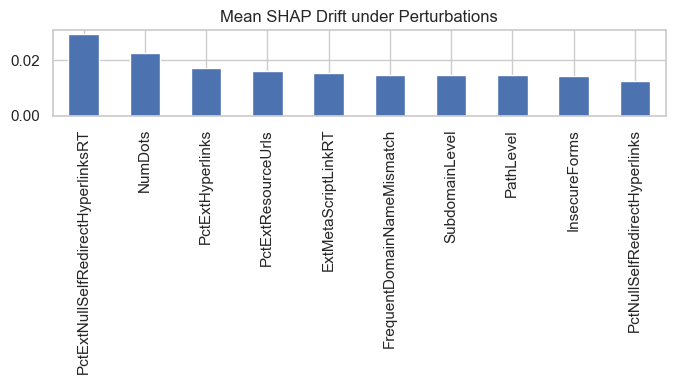

✅ Generated: accuracy_vs_epsilon.png, feature_sensitivity.png, shap_shift.png


In [14]:
# ==========================================
# SHAP Explainability Drift
# ==========================================
import shap
from sklearn.neural_network import MLPClassifier

# Refit simple sklearn MLP for SHAP compatibility
clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)
clf.fit(X_train, y_train)
explainer = shap.Explainer(clf.predict, X_train[:200])
shap_clean = explainer(X_test[:100])
X_noisy = X_test.copy() + np.random.normal(0, 0.05, X_test.shape)
shap_adv = explainer(X_noisy[:100])
drift = np.abs(shap_adv.values - shap_clean.values).mean(axis=0)

drift_series = pd.Series(drift, index=cols).sort_values(ascending=False)
drift_series.head(10).plot(kind="bar")
plt.title("Mean SHAP Drift under Perturbations")
plt.tight_layout()
plt.savefig("shap_shift.png", dpi=300)
plt.show()

print("✅ Generated: accuracy_vs_epsilon.png, feature_sensitivity.png, shap_shift.png")

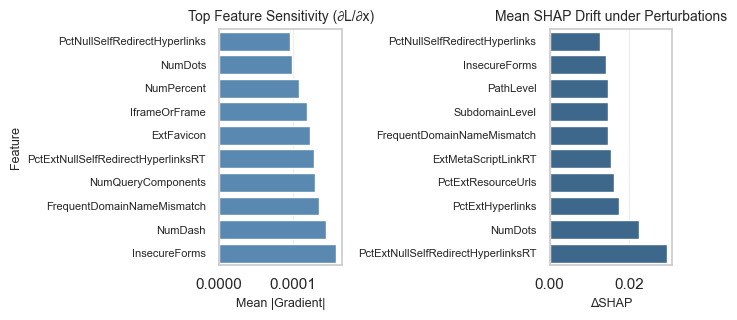

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume top_k (Series) and drift_series (Series) already defined
top_grad = top_k.sort_values()  # ascending for horizontal bars
top_shap = drift_series.head(10).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(7.2, 3.5), sharey=False)

# --- Left: Gradient Sensitivity ---
sns.barplot(x=top_grad.values, y=top_grad.index, ax=axes[0], color="#4B8BBE")
axes[0].set_title("Top Feature Sensitivity (∂L/∂x)", fontsize=10)
axes[0].set_xlabel("Mean |Gradient|", fontsize=9)
axes[0].set_ylabel("Feature", fontsize=9)
axes[0].tick_params(axis='y', labelsize=8)
axes[0].grid(axis='x', alpha=0.3)

# --- Right: SHAP Drift ---
sns.barplot(x=top_shap.values, y=top_shap.index, ax=axes[1], color="#306998")
axes[1].set_title("Mean SHAP Drift under Perturbations", fontsize=10)
axes[1].set_xlabel("ΔSHAP", fontsize=9)
axes[1].set_ylabel("")  # suppress duplicate label
axes[1].tick_params(axis='y', labelsize=8)
axes[1].grid(axis='x', alpha=0.3)

# --- Layout tuning ---
plt.tight_layout(pad=1.5, w_pad=0.8)
plt.savefig("feature_vulnerability_2panel_hbar.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
# =======================================================
# Optional: UNSW-NB15 Robustness Evaluation
# =======================================================
df_unsw = pd.read_csv("UNSW_NB15_training-set.csv")
df_unsw = df_unsw.drop(columns=['srcip','dstip','attack_cat'], errors='ignore')

# Encode categoricals (proto, state, service)
for c in df_unsw.select_dtypes('object').columns:
    df_unsw[c] = LabelEncoder().fit_transform(df_unsw[c])

X_unsw = df_unsw.drop(columns=['label']).values
y_unsw = df_unsw['label'].values  # 0=normal, 1=attack
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_unsw, y_unsw, test_size=0.2, random_state=42)
X_train_u = StandardScaler().fit_transform(X_train_u)
X_test_u = StandardScaler().fit_transform(X_test_u)

# Reuse your robustness evaluation loop here (FGSM/PGD, RI computation)

In [23]:
# ============================================================
# Generic Robustness Evaluation Loop (FGSM + PGD)
# Works for any trained model and dataset (e.g., Phishing, UNSW-NB15)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import torch

# --- Assumes the following exist:
# model: trained PyTorch model (MLP, etc.)
# X_test_t, y_test_t: torch tensors (test data)
# fgsm_attack, pgd_attack, eval_accuracy: defined previously
# criterion: loss function

def evaluate_robustness(model, X_test_t, y_test_t, dataset_name="dataset", 
                        eps_range=np.linspace(0, 0.3, 10), save_path=None):
    """Evaluate FGSM and PGD robustness curves and compute RI metrics."""
    model.eval()
    acc_fgsm, acc_pgd = [], []

    print(f"\n=== Evaluating robustness on {dataset_name} ===")
    for eps in eps_range:
        # FGSM
        X_adv_fgsm = fgsm_attack(model, X_test_t, y_test_t, eps)
        acc_fgsm.append(eval_accuracy(model, X_adv_fgsm, y_test_t))

        # PGD
        X_adv_pgd = pgd_attack(model, X_test_t, y_test_t, eps)
        acc_pgd.append(eval_accuracy(model, X_adv_pgd, y_test_t))

        print(f"ε={eps:.3f} → FGSM={acc_fgsm[-1]:.3f}, PGD={acc_pgd[-1]:.3f}")

    # Compute Robustness Index (RI) as area under curve
    RI_fgsm = np.trapz(acc_fgsm, eps_range) / (eps_range[-1] - eps_range[0])
    RI_pgd = np.trapz(acc_pgd, eps_range) / (eps_range[-1] - eps_range[0])

    print(f"\nRobustness Index (FGSM) = {RI_fgsm:.3f}")
    print(f"Robustness Index (PGD)  = {RI_pgd:.3f}")

    # --- Plot curves ---
    plt.figure(figsize=(7, 4))
    plt.plot(eps_range, acc_fgsm, marker='o', label=f"FGSM (RI={RI_fgsm:.2f})")
    plt.plot(eps_range, acc_pgd, marker='s', label=f"PGD (RI={RI_pgd:.2f})")
    plt.xlabel("Perturbation Magnitude (ε)")
    plt.ylabel("Accuracy")
    plt.title(f"Adversarial Robustness on {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        out_file = f"{save_path}/accuracy_vs_epsilon_{dataset_name}.png"
        plt.savefig(out_file, dpi=300)
        print(f"✅ Saved figure: {out_file}")

    plt.show()
    return {
        "dataset": dataset_name,
        "acc_fgsm": acc_fgsm,
        "acc_pgd": acc_pgd,
        "RI_fgsm": RI_fgsm,
        "RI_pgd": RI_pgd
    }

In [24]:
# =======================================================
# Train MLP on UNSW-NB15 dataset (for robustness eval)
# =======================================================

# Convert UNSW data to tensors
X_train_u_t = torch.tensor(X_train_u, dtype=torch.float32).to(device)
y_train_u_t = torch.tensor(y_train_u, dtype=torch.long).to(device)
X_test_u_t  = torch.tensor(X_test_u,  dtype=torch.float32).to(device)
y_test_u_t  = torch.tensor(y_test_u,  dtype=torch.long).to(device)

# Define model, loss, optimizer (same architecture as phishing model)
model_unsw = MLP(X_train_u.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unsw.parameters(), lr=0.001)

# --- Training loop ---
epochs = 20
for epoch in range(epochs):
    model_unsw.train()
    optimizer.zero_grad()
    outputs = model_unsw(X_train_u_t)
    loss = criterion(outputs, y_train_u_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        acc_train = eval_accuracy(model_unsw, X_train_u_t, y_train_u_t)
        acc_test  = eval_accuracy(model_unsw, X_test_u_t, y_test_u_t)
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {acc_train:.3f} | Test Acc: {acc_test:.3f}")

print("✅ UNSW model training complete.")

Epoch 5/20 | Train Acc: 0.607 | Test Acc: 0.607
Epoch 10/20 | Train Acc: 0.746 | Test Acc: 0.739
Epoch 15/20 | Train Acc: 0.755 | Test Acc: 0.751
Epoch 20/20 | Train Acc: 0.786 | Test Acc: 0.774
✅ UNSW model training complete.



=== Evaluating robustness on phishing ===
ε=0.000 → FGSM=0.864, PGD=0.864
ε=0.033 → FGSM=0.817, PGD=0.817
ε=0.067 → FGSM=0.761, PGD=0.757
ε=0.100 → FGSM=0.702, PGD=0.695
ε=0.133 → FGSM=0.640, PGD=0.695
ε=0.167 → FGSM=0.572, PGD=0.695
ε=0.200 → FGSM=0.516, PGD=0.695
ε=0.233 → FGSM=0.465, PGD=0.695
ε=0.267 → FGSM=0.408, PGD=0.695
ε=0.300 → FGSM=0.357, PGD=0.695

Robustness Index (FGSM) = 0.610
Robustness Index (PGD)  = 0.725
✅ Saved figure: ./accuracy_vs_epsilon_phishing.png


/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/2903763369.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_fgsm = np.trapz(acc_fgsm, eps_range) / (eps_range[-1] - eps_range[0])
/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/2903763369.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_pgd = np.trapz(acc_pgd, eps_range) / (eps_range[-1] - eps_range[0])


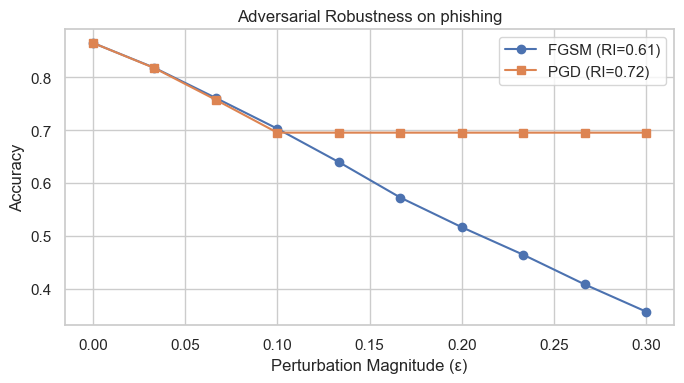


=== Evaluating robustness on unsw ===
ε=0.000 → FGSM=0.774, PGD=0.774
ε=0.033 → FGSM=0.759, PGD=0.758
ε=0.067 → FGSM=0.748, PGD=0.747
ε=0.100 → FGSM=0.725, PGD=0.722
ε=0.133 → FGSM=0.679, PGD=0.722
ε=0.167 → FGSM=0.663, PGD=0.722
ε=0.200 → FGSM=0.648, PGD=0.722
ε=0.233 → FGSM=0.626, PGD=0.722
ε=0.267 → FGSM=0.585, PGD=0.722
ε=0.300 → FGSM=0.505, PGD=0.722

Robustness Index (FGSM) = 0.675
Robustness Index (PGD)  = 0.732
✅ Saved figure: ./accuracy_vs_epsilon_unsw.png


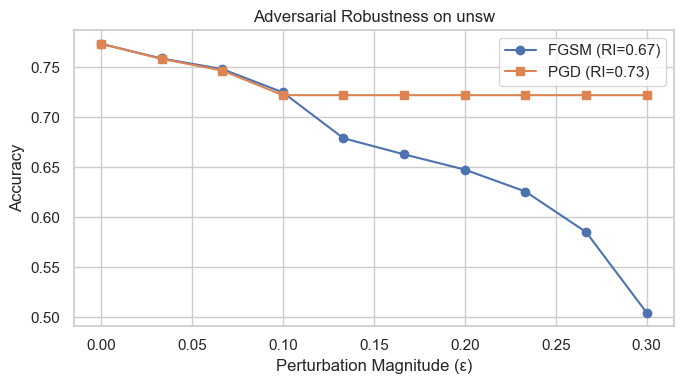


=== Cross-Domain Robustness Comparison ===
Dataset      RI_FGSM    RI_PGD    
Phishing     0.610      0.725     
UNSW-NB15    0.675      0.732     


In [25]:
# For Phishing dataset
results_phish = evaluate_robustness(model, X_test_t, y_test_t, 
                                    dataset_name="phishing", save_path=".")

# For UNSW-NB15 dataset (assuming you have X_test_u, y_test_u)
X_test_u_t = torch.tensor(X_test_u, dtype=torch.float32).to(device)
y_test_u_t = torch.tensor(y_test_u, dtype=torch.long).to(device)

results_unsw = evaluate_robustness(model_unsw, X_test_u_t, y_test_u_t, 
                                   dataset_name="unsw", save_path=".")

# Summarize comparison
print("\n=== Cross-Domain Robustness Comparison ===")
print(f"{'Dataset':<12} {'RI_FGSM':<10} {'RI_PGD':<10}")
print(f"{'Phishing':<12} {results_phish['RI_fgsm']:<10.3f} {results_phish['RI_pgd']:<10.3f}")
print(f"{'UNSW-NB15':<12} {results_unsw['RI_fgsm']:<10.3f} {results_unsw['RI_pgd']:<10.3f}")

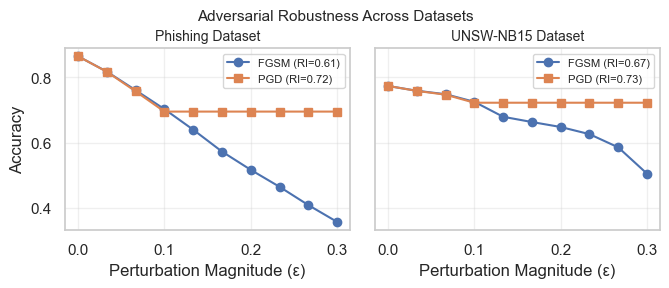

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# --- Left: Phishing ---
axes[0].plot(epsilons, results_phish["acc_fgsm"], 'o-', label=f"FGSM (RI={results_phish['RI_fgsm']:.2f})")
axes[0].plot(epsilons, results_phish["acc_pgd"], 's-', label=f"PGD (RI={results_phish['RI_pgd']:.2f})")
axes[0].set_title("Phishing Dataset", fontsize=10)
axes[0].set_xlabel("Perturbation Magnitude (ε)")
axes[0].set_ylabel("Accuracy")
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# --- Right: UNSW ---
axes[1].plot(epsilons, results_unsw["acc_fgsm"], 'o-', label=f"FGSM (RI={results_unsw['RI_fgsm']:.2f})")
axes[1].plot(epsilons, results_unsw["acc_pgd"], 's-', label=f"PGD (RI={results_unsw['RI_pgd']:.2f})")
axes[1].set_title("UNSW-NB15 Dataset", fontsize=10)
axes[1].set_xlabel("Perturbation Magnitude (ε)")
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

# --- Compact main title ---
fig.suptitle("Adversarial Robustness Across Datasets", fontsize=11)

# --- Tight layout with less whitespace ---
fig.tight_layout(pad=1.5)                 # smaller padding overall
fig.subplots_adjust(top=0.85)             # reduce space reserved for suptitle

plt.savefig("accuracy_vs_e_2panel.png", dpi=300, bbox_inches="tight")
plt.show()

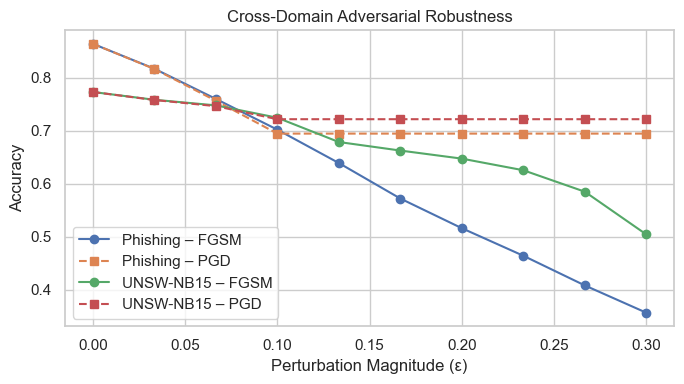

In [26]:

plt.figure(figsize=(7, 4))
plt.plot(np.linspace(0, 0.3, 10), results_phish["acc_fgsm"], 'o-', label="Phishing – FGSM")
plt.plot(np.linspace(0, 0.3, 10), results_phish["acc_pgd"], 's--', label="Phishing – PGD")
plt.plot(np.linspace(0, 0.3, 10), results_unsw["acc_fgsm"], 'o-', label="UNSW-NB15 – FGSM")
plt.plot(np.linspace(0, 0.3, 10), results_unsw["acc_pgd"], 's--', label="UNSW-NB15 – PGD")

plt.xlabel("Perturbation Magnitude (ε)")
plt.ylabel("Accuracy")
plt.title("Cross-Domain Adversarial Robustness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cross_domain_robustness.png", dpi=300)
plt.show()

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def adversarial_train_and_evaluate(
    model_class,
    X_train_t,
    y_train_t,
    X_test_t,
    y_test_t,
    dataset_name="dataset",
    device="cpu",
    epsilon_train=0.05,
    adv_ratio=0.2,
    epochs=20,
    batch_size=128,
    lr=0.001,
    epsilons=np.linspace(0, 0.3, 10),
    attack_fns=("fgsm_attack", "pgd_attack"),
    plot=True,
    save_path="figures/robustness_curve_ablation.png"
):
    """
    Performs FGSM-based adversarial training and evaluates model robustness.

    Parameters
    ----------
    model_class : callable
        Model constructor, e.g. MLP(input_dim)
    X_train_t, y_train_t, X_test_t, y_test_t : torch.Tensor
        Training and test tensors.
    dataset_name : str
        Dataset label for logging and figure titles.
    device : str
        Device to use ('cpu' or 'cuda').
    epsilon_train : float
        Perturbation magnitude for FGSM adversarial training.
    adv_ratio : float
        Fraction of adversarial samples per training batch.
    epochs : int
        Number of training epochs.
    batch_size : int
        Batch size.
    lr : float
        Learning rate.
    epsilons : array-like
        Range of ε values for robustness evaluation.
    attack_fns : tuple
        Names or references to attack functions (fgsm_attack, pgd_attack).
    plot : bool
        Whether to display robustness curve plot.
    save_path : str
        Path to save robustness curve figure.

    Returns
    -------
    model_adv : nn.Module
        The adversarially trained model.
    results_adv : dict
        Dictionary with clean accuracy, RI_FGSM, RI_PGD, accuracy arrays.
    """
    fgsm_attack_fn, pgd_attack_fn = attack_fns

    # Initialize model
    model_adv = model_class(X_train_t.shape[1]).to(device)
    optimizer = optim.Adam(model_adv.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"=== Adversarial Training on {dataset_name} ===")
    print(f"Epsilon={epsilon_train}, Adv Ratio={adv_ratio}")

    # Training loop
    num_batches = len(X_train_t) // batch_size
    for epoch in range(epochs):
        model_adv.train()
        perm = torch.randperm(X_train_t.size(0))
        for i in range(num_batches):
            idx = perm[i * batch_size:(i + 1) * batch_size]
            xb, yb = X_train_t[idx], y_train_t[idx]

            # Generate adversarial examples for 20% of batch
            if np.random.rand() < adv_ratio:
                xb = fgsm_attack_fn(model_adv, xb, yb, epsilon_train)

            optimizer.zero_grad()
            outputs = model_adv(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} complete")

    print(f"✅ Adversarial training complete for {dataset_name}.\n")

    # --- Evaluation ---
    def eval_accuracy(model, X, y):
        model.eval()
        with torch.no_grad():
            preds = model(X).argmax(dim=1)
        return (preds == y).float().mean().item()

    acc_clean = eval_accuracy(model_adv, X_test_t, y_test_t)
    print(f"Clean accuracy (adv-trained): {acc_clean:.4f}")

    acc_fgsm, acc_pgd = [], []
    for eps in epsilons:
        X_fgsm = fgsm_attack_fn(model_adv, X_test_t, y_test_t, eps)
        X_pgd  = pgd_attack_fn(model_adv, X_test_t, y_test_t, eps)
        acc_fgsm.append(eval_accuracy(model_adv, X_fgsm, y_test_t))
        acc_pgd.append(eval_accuracy(model_adv, X_pgd,  y_test_t))
        print(f"ε={eps:.3f} → FGSM={acc_fgsm[-1]:.3f}, PGD={acc_pgd[-1]:.3f}")

    RI_fgsm = np.trapz(acc_fgsm, epsilons) / (epsilons[-1] - epsilons[0])
    RI_pgd  = np.trapz(acc_pgd, epsilons) / (epsilons[-1] - epsilons[0])
    print(f"RI_FGSM={RI_fgsm:.3f}, RI_PGD={RI_pgd:.3f}\n")

    results_adv = {
        "dataset": dataset_name,
        "acc_clean": acc_clean,
        "acc_fgsm": acc_fgsm,
        "acc_pgd": acc_pgd,
        "RI_fgsm": RI_fgsm,
        "RI_pgd": RI_pgd
    }

    # --- Plot robustness curve ---
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(epsilons, acc_fgsm, 'o-', label=f"FGSM (RI={RI_fgsm:.2f})")
        plt.plot(epsilons, acc_pgd, 's-', label=f"PGD (RI={RI_pgd:.2f})")
        plt.xlabel("Perturbation Magnitude (ε)")
        plt.ylabel("Accuracy")
        plt.title(f"{dataset_name}: Adversarially Trained Model Robustness")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()

    return model_adv, results_adv

=== Adversarial Training on Phishing ===
Epsilon=0.05, Adv Ratio=0.2
Epoch 1/20 complete
Epoch 5/20 complete
Epoch 10/20 complete
Epoch 15/20 complete
Epoch 20/20 complete
✅ Adversarial training complete for Phishing.

Clean accuracy (adv-trained): 0.9755
ε=0.000 → FGSM=0.978, PGD=0.978
ε=0.033 → FGSM=0.958, PGD=0.958
ε=0.067 → FGSM=0.926, PGD=0.924
ε=0.100 → FGSM=0.853, PGD=0.846
ε=0.133 → FGSM=0.769, PGD=0.846
ε=0.167 → FGSM=0.680, PGD=0.846
ε=0.200 → FGSM=0.590, PGD=0.846
ε=0.233 → FGSM=0.507, PGD=0.846
ε=0.267 → FGSM=0.421, PGD=0.846
ε=0.300 → FGSM=0.349, PGD=0.846
RI_FGSM=0.707, RI_PGD=0.875



/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/631914523.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_fgsm = np.trapz(acc_fgsm, epsilons) / (epsilons[-1] - epsilons[0])
/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/631914523.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_pgd  = np.trapz(acc_pgd, epsilons) / (epsilons[-1] - epsilons[0])


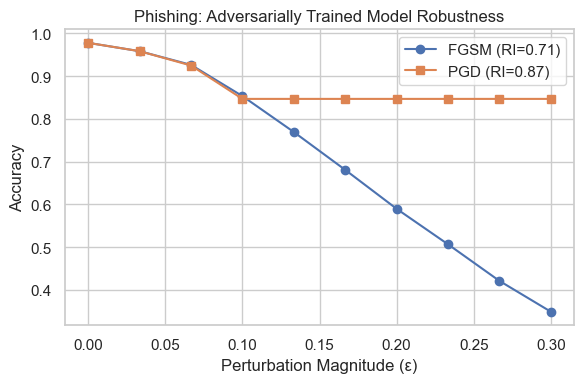

In [37]:
model_adv_phish, results_adv_phish = adversarial_train_and_evaluate(
    MLP,
    X_train_t,
    y_train_t,
    X_test_t,
    y_test_t,
    dataset_name="Phishing",
    device=device,
    epsilon_train=0.05,
    adv_ratio=0.2,
    epochs=20,
    batch_size=128,
    attack_fns=(fgsm_attack, pgd_attack),
    save_path="robustness_curve_ablation_phish.png"
)

=== Adversarial Training on UNSW-NB15 ===
Epsilon=0.05, Adv Ratio=0.2
Epoch 1/20 complete
Epoch 5/20 complete
Epoch 10/20 complete
Epoch 15/20 complete
Epoch 20/20 complete
✅ Adversarial training complete for UNSW-NB15.

Clean accuracy (adv-trained): 0.9968
ε=0.000 → FGSM=0.997, PGD=0.997
ε=0.033 → FGSM=0.983, PGD=0.983
ε=0.067 → FGSM=0.954, PGD=0.952
ε=0.100 → FGSM=0.908, PGD=0.903
ε=0.133 → FGSM=0.848, PGD=0.903
ε=0.167 → FGSM=0.767, PGD=0.903
ε=0.200 → FGSM=0.683, PGD=0.903
ε=0.233 → FGSM=0.612, PGD=0.903
ε=0.267 → FGSM=0.544, PGD=0.903
ε=0.300 → FGSM=0.476, PGD=0.903
RI_FGSM=0.782, RI_PGD=0.923



/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/631914523.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_fgsm = np.trapz(acc_fgsm, epsilons) / (epsilons[-1] - epsilons[0])
/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_89389/631914523.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  RI_pgd  = np.trapz(acc_pgd, epsilons) / (epsilons[-1] - epsilons[0])


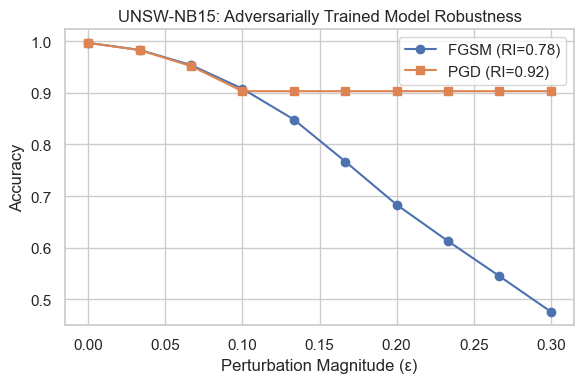

In [38]:
model_adv_unsw, results_adv_unsw = adversarial_train_and_evaluate(
    MLP,
    X_train_u_t,
    y_train_u_t,
    X_test_u_t,
    y_test_u_t,
    dataset_name="UNSW-NB15",
    device=device,
    epsilon_train=0.05,
    adv_ratio=0.2,
    epochs=20,
    batch_size=128,
    attack_fns=(fgsm_attack, pgd_attack),
    save_path="robustness_curve_ablation_unsw.png"
)

In [45]:
def plot_ablation_comparison(
    results_base_phish,
    results_adv_phish,
    results_base_unsw,
    results_adv_unsw,
    epsilons,
    attacks=("fgsm", "pgd"),
    save_path="robustness_curve_ablation_2panel.png",
    show=True
):
    """
    Plot baseline vs adversarially trained model robustness for two datasets,
    supporting FGSM, PGD, or both attacks.

    Parameters
    ----------
    results_base_phish, results_adv_phish : dict
        Baseline and adversarially trained results for the Phishing dataset.
        Must include keys: 'acc_fgsm', 'acc_pgd', 'RI_fgsm', 'RI_pgd'.
    results_base_unsw, results_adv_unsw : dict
        Same structure for UNSW-NB15.
    epsilons : array-like
        Perturbation magnitudes (ε values).
    attacks : tuple
        Attack types to plot. Options: ('fgsm',), ('pgd',), or ('fgsm', 'pgd').
    save_path : str
        Path to save figure.
    show : bool
        Whether to display figure.

    Returns
    -------
    None (saves figure)
    """

    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

    colors = {"fgsm": "C0", "pgd": "C1"}
    markers = {"fgsm": "o", "pgd": "s"}

    # Helper to add attack curves for one dataset
    def plot_dataset(ax, results_base, results_adv, title):
        for attack in attacks:
            acc_key = f"acc_{attack}"
            RI_key = f"RI_{attack}"

            # Baseline curve
            ax.plot(
                epsilons, results_base[acc_key],
                linestyle="--", marker=markers[attack], color=colors[attack],
                label=f"Baseline {attack.upper()} (RI={results_base[RI_key]:.2f})"
            )
            # Adversarially trained curve
            ax.plot(
                epsilons, results_adv[acc_key],
                linestyle="-", marker=markers[attack], color=colors[attack],
                label=f"Adv-Trained {attack.upper()} (RI={results_adv[RI_key]:.2f})"
            )

        ax.set_title(title, fontsize=10)
        ax.set_xlabel("Perturbation Magnitude (ε)")
        ax.set_ylabel("Accuracy")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # --- Left: Phishing ---
    plot_dataset(axes[0], results_base_phish, results_adv_phish, "Phishing Dataset")

    # --- Right: UNSW-NB15 ---
    plot_dataset(axes[1], results_base_unsw, results_adv_unsw, "UNSW-NB15 Dataset")

    # --- Shared title and layout ---
    if len(attacks) == 2:
        main_title = "Effect of Adversarial Training on FGSM and PGD Robustness"
    else:
        main_title = f"Effect of Adversarial Training on {attacks[0].upper()} Robustness"

    fig.suptitle(main_title, fontsize=11)
    fig.tight_layout(pad=1.5)
    fig.subplots_adjust(top=0.85)

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    print(f"✅ Saved ablation comparison figure to: {save_path}")

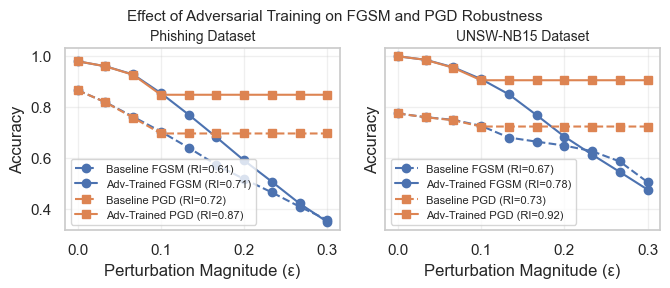

✅ Saved ablation comparison figure to: robustness_curve_ablation_fgsm_pgd.png


In [47]:
plot_ablation_comparison(
    results_phish,
    results_adv_phish,
    results_unsw,
    results_adv_unsw,
    epsilons=np.linspace(0, 0.3, 10),
    attacks=("fgsm", "pgd"),
    save_path="robustness_curve_ablation_fgsm_pgd.png"
)

In [27]:
import shap
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import shap
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def compute_shap_drift_matrix(model, X_test_t, y_test_t, feature_names, epsilons=None,
                              num_samples=256, device="cpu", attack_fn=None,
                              top_k_features=10,
                              title="Mean SHAP Attribution Drift Across Perturbations",
                              save_path="figures/shap_drift_heatmap.png",
                              show_plot=True):
    """
    Compute and visualize SHAP attribution drift across adversarial perturbations.

    Parameters
    ----------
    model : torch.nn.Module
        Trained model to evaluate.
    X_test_t, y_test_t : torch.Tensor
        Test features and labels (tensors).
    feature_names : list
        Names of input features.
    epsilons : array-like
        List or np.array of perturbation magnitudes (default: np.linspace(0, 0.3, 10)).
    num_samples : int
        Number of test samples to use for SHAP analysis (default: 256).
    device : str
        Device to run model on ('cpu' or 'cuda').
    attack_fn : callable
        Function(model, X, y, eps) -> perturbed X_adv (default: FGSM).
    top_k_features : int
        Number of top features to visualize in the heatmap.
    title : str
        Title for heatmap figure.
    save_path : str
        File path for saving the resulting heatmap.
    show_plot : bool
        If True, display heatmap with plt.show().

    Returns
    -------
    df : pd.DataFrame
        DataFrame of shape [len(epsilons), top_k_features] containing mean SHAP drift per feature.
    shap_drift_matrix : np.ndarray
        Full array of shape [len(epsilons), num_features] with SHAP drift values.
    """

    if epsilons is None:
        epsilons = np.linspace(0, 0.3, 10)
    if attack_fn is None:
        raise ValueError("You must provide an attack_fn such as fgsm_attack or pgd_attack")

    # Convert to NumPy
    X_test_np = X_test_t.cpu().numpy()

    # Masker + Explainer
    masker = shap.maskers.Independent(X_test_np)

    def predict_fn(x):
        x_t = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            probs = torch.nn.functional.softmax(model(x_t), dim=1)
        return probs.cpu().numpy()

    explainer = shap.Explainer(predict_fn, masker, feature_names=feature_names)

    # Subset for SHAP sampling
    subset_idx = np.random.choice(len(X_test_np), size=num_samples, replace=False)
    X_subset = X_test_np[subset_idx]
    y_subset = y_test_t.cpu().numpy()[subset_idx]

    # Baseline SHAP values
    shap_values_clean = explainer(X_subset)
    base_shap = np.array(shap_values_clean.values)  # [samples, features, outputs]

    shap_drift_matrix = []

    for eps in epsilons:
        X_adv = attack_fn(model, torch.tensor(X_subset, dtype=torch.float32).to(device),
                          torch.tensor(y_subset, dtype=torch.long).to(device), eps)
        X_adv_np = X_adv.detach().cpu().numpy()

        shap_values_adv = explainer(X_adv_np)
        adv_shap = np.array(shap_values_adv.values)

        # Compute mean absolute drift per feature, averaged over samples + outputs
        drift = np.mean(np.abs(adv_shap - base_shap), axis=(0, 2))
        shap_drift_matrix.append(drift)

    shap_drift_matrix = np.stack(shap_drift_matrix)  # shape: [len(epsilons), n_features]

    # Build DataFrame for top-K features (based on mean drift)
    top_indices = np.argsort(-np.mean(shap_drift_matrix, axis=0))[:top_k_features]
    print("shap_drift_matrix shape:", shap_drift_matrix.shape)
    print("len(feature_names):", len(feature_names))
    df = pd.DataFrame(
        shap_drift_matrix[:, top_indices],
        index=[f"ε={e:.2f}" for e in epsilons],
        columns=[feature_names[i] for i in top_indices]
    )

    # Plot heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(df, cmap="Reds", cbar_kws={'label': 'ΔSHAP'})
    plt.xlabel("Feature")
    plt.ylabel("Perturbation Level (ε)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    if show_plot:
        plt.show()
    else:
        plt.close()

    return df, shap_drift_matrix

shap_drift_matrix shape: (10, 48)
len(feature_names): 49


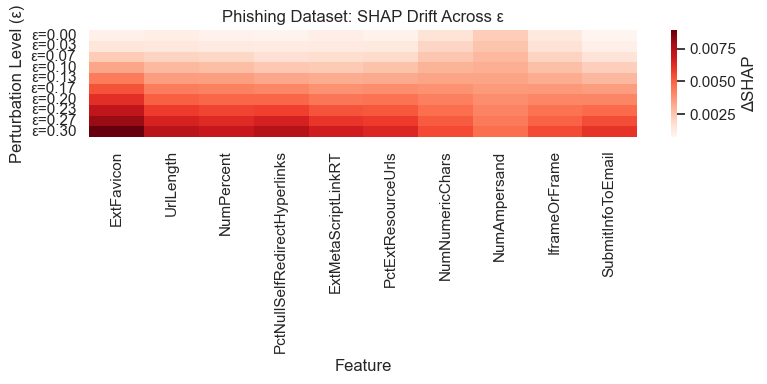

In [28]:
feature_names_phish = [c for c in df.columns if c != 'CLASS_LABEL']
df_phish, phish_drift = compute_shap_drift_matrix(
    model=model,
    X_test_t=X_test_t,
    y_test_t=y_test_t,
    feature_names=feature_names_phish,
    attack_fn=fgsm_attack,
    device=device,
    title="Phishing Dataset: SHAP Drift Across ε",
    save_path="shap_drift_heatmap_phish.png"
)

shap_drift_matrix shape: (10, 43)
len(feature_names): 43


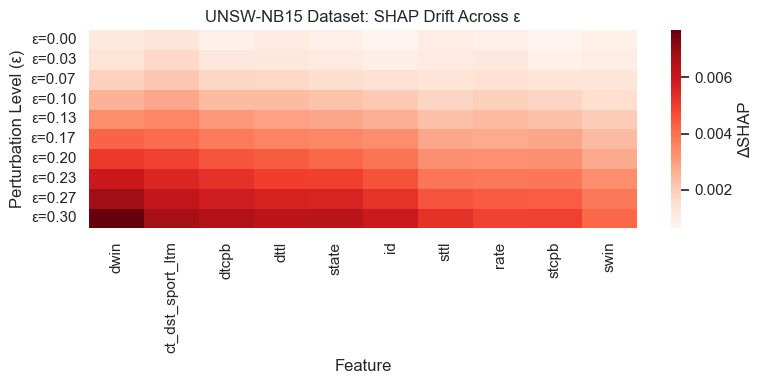

In [29]:
feature_names_unsw = [c for c in df_unsw.columns if c != 'label']
df_unsw, unsw_drift = compute_shap_drift_matrix(
    model=model_unsw,
    X_test_t=X_test_u_t,
    y_test_t=y_test_u_t,
    feature_names=feature_names_unsw,
    attack_fn=fgsm_attack,
    device=device,
    title="UNSW-NB15 Dataset: SHAP Drift Across ε",
    save_path="shap_drift_heatmap_unsw.png"
)

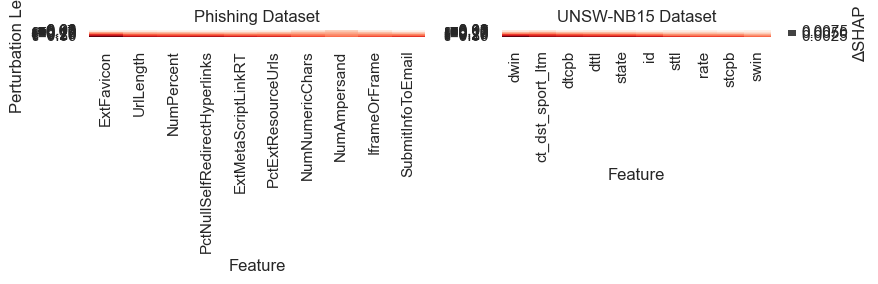

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

sns.heatmap(df_phish, cmap="Reds", cbar=False, ax=axes[0])
axes[0].set_title("Phishing Dataset")
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Perturbation Level (ε)")

sns.heatmap(df_unsw, cmap="Reds", cbar_kws={'label': 'ΔSHAP'}, ax=axes[1])
axes[1].set_title("UNSW-NB15 Dataset")
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("combined_shap_drift.png", dpi=300)
plt.show()